## Load Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tedda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tedda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Check version of Python and Tensorflow; There are some compatibility issues with TF 2.3, numpy 1.20, and Python 3.8
#If interested, follow the ticket on Github here: https://github.com/tensorflow/models/issues/9706
from platform import python_version

print("Python Version:", python_version())
print("Tensorflow Version:", tf.__version__)

Python Version: 3.8.8
Tensorflow Version: 2.3.0


## Load in the raw amazon text data

In [3]:
URL = 'C:/Users/tedda/Desktop/Data Science Portfolio/Machine Learning/Sentiment Analysis/NLTK & TF Sentiment Analysis on Amazon Reviews/Raw Datasets/amazon_cells_labelled.txt'
amazon_data = pd.read_csv(URL, delimiter = '\t', names = ['Review','Label'])

In [4]:
amazon_data.head() #show the first five reviews and their labels in our dataset

,Review,Label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
amazon_data.describe()

,Label
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


<AxesSubplot:xlabel='Label', ylabel='count'>

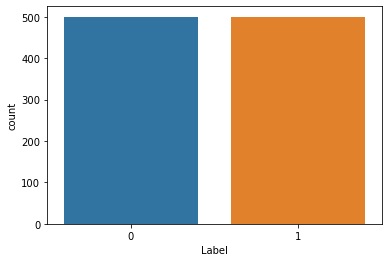

In [6]:
sns.countplot(x='Label', data = amazon_data) #Plot the distribution of positive and negative reviews in our dataset

# Exploratory Data Analysis (Part II, B, 1)

### Explore presence of unusual characters in the reviews (B1)

In [7]:
reviews = amazon_data['Review'] #split out the reviews from the labels to find the individual characters in each review
char_list = []
for review in reviews:
    for char in review:
        if char not in char_list: #If the character is not in our char_list, then append it. Only unique characters added
            char_list.append(char)
char_list = sorted(char_list)
print(char_list) #this is a list of all individual characters in the reviews

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


There are several punctuations and symbols which need to be parsed out of the data. The alphabet characters must be lower cased.

### Explore Vocabulary Size (B1)

In [8]:
#Create the tokenizer
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,oov_token="<UKN>")

#Fit the tokenizer on the text
tokenizer.fit_on_texts(reviews)

#Extract the word index for each unique word in the text
vocabulary = tokenizer.word_index
vocabulary = sorted(vocabulary)
print("Vocabulary Size:",len(vocabulary)+1)

Vocabulary Size: 1880


### Explore Proposed Word Embedding Length

Given that the vocabulary size is under 2000 for 1000 reviews, I have decided to double the minimum recommended word embedding length of 8 and use 16 as my proposed Word Embedding Length.

### Explore Statistical Justification for the chosen maximum sequence length (B1)

In [9]:
length_list = []
for length in reviews:
    length_list.append(len(length.split(' ')))

max_review_length = np.max(length_list)
print("Maximum Sequence Length:", max_review_length) #this is the maximum sequence length

Maximum Sequence Length: 30


# Data Preprocessing (Part II, B, 2-3)

In [10]:
stopwds = stopwords.words('english')
important_review_words_list = []
for review in amazon_data['Review']:
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    lemmatizer = nltk.WordNetLemmatizer()
    review = [lemmatizer.lemmatize(word) for word in review]
    review = [word for word in review if not word in stopwds]
    review = ' '.join(review)
    important_review_words_list.append(review)
important_review_words_list[1]

'good case excellent value'

In [11]:
#After lemmatization and removal of stop words, set the final review word list as a np array
x = np.array(important_review_words_list)

In [12]:
#Use OneHotEncoding on our labels to get a 2d np array
onehot = OneHotEncoder(sparse=False).fit_transform(amazon_data['Label'].to_numpy().reshape(-1,1))
onehot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [13]:
#split our dataset into training (80%) and test sets (20%); Stratify is set to maintain even split of our labels
x_train, x_test, y_train, y_test = train_test_split(x, onehot, test_size = 0.2, random_state = 1234, stratify = onehot)

In [14]:
#Check the size of our training and test sets
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (800,)
x_test shape: (200,)
y_train shape: (800, 2)
y_test shape: (200, 2)


In [15]:
#Check if stratify worked
df_y=pd.DataFrame(y_train)
good = df_y[df_y[1]==1.0]
bad = df_y[df_y[0]==1.0]
print("Good Reviews in Training Set:",good.shape[0])
print("Bad Reviews in Training Set:", bad.shape[0])

Good Reviews in Training Set: 400
Bad Reviews in Training Set: 400


In [16]:
#Create the tokenizer
tokenizer = Tokenizer(num_words = len(vocabulary)+1, oov_token="<UKN>")

#Fit the tokenizer on the text
tokenizer.fit_on_texts(x_train)

#Extract the word index for each unique word in the text
word_index = tokenizer.word_index

In [17]:
#Create sequences of each review for our training and testing sets
x_train_seq = tokenizer.texts_to_sequences(x_train)
pre_pad_train = pad_sequences(x_train_seq, maxlen = max_review_length, padding='pre')

x_test_seq = tokenizer.texts_to_sequences(x_test)
pre_pad_test = pad_sequences(x_test_seq, maxlen = max_review_length, padding='pre')

In [18]:
#Convert the training and test sets to np arrays
x_train_padded = np.array(pre_pad_train)
y_train_labels = np.array(y_train)

x_test_padded = np.array(pre_pad_test)
y_test_labels = np.array(y_test)

In [19]:
print(x_train[123])
x_train_padded[123]

doe everything


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 26, 97])

In [20]:
# Export the cleaned training and test sets
pd.DataFrame(x_train_padded).to_csv('C:/Users/tedda/Desktop/Data Science Portfolio/Machine Learning/Sentiment Analysis/NLTK & TF Sentiment Analysis on Amazon Reviews/Cleansed Datasets/Training_Data.csv')
pd.DataFrame(y_train_labels).to_csv('C:/Users/tedda/Desktop/Data Science Portfolio/Machine Learning/Sentiment Analysis/NLTK & TF Sentiment Analysis on Amazon Reviews/Cleansed Datasets/Training_Labels.csv')
pd.DataFrame(x_test_padded).to_csv('C:/Users/tedda/Desktop/Data Science Portfolio/Machine Learning/Sentiment Analysis/NLTK & TF Sentiment Analysis on Amazon Reviews/Cleansed Datasets/Test_Data.csv')
pd.DataFrame(y_test_labels).to_csv('C:/Users/tedda/Desktop/Data Science Portfolio/Machine Learning/Sentiment Analysis/NLTK & TF Sentiment Analysis on Amazon Reviews/Cleansed Datasets/Test_Labels.csv')

# Sentiment Analysis

### Build the Model

In [21]:
vocab_size = len(word_index)+1
embedding_dim = 16
max_length = max_review_length

model = keras.Sequential(name = "Dense_model")
model.add(keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_review_length))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation = 'sigmoid'))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Dense(64, activation = 'sigmoid'))
model.add(keras.layers.Dense(2, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

Model: "Dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 16)            21968     
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               61568     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 91,922
Trainable params: 91,922
Non-trainable params: 0
___________________________________________________

In [22]:
callback = EarlyStopping(monitor = 'val_accuracy', patience = 3)
history = model.fit(x_train_padded, y_train_labels, batch_size = 32, epochs = 15, validation_split = 0.1, 
                    callbacks = callback, verbose = True)

Epoch 1/15
23/23 [==============================] - 0s 17ms/step - loss: 0.7267 - accuracy: 0.4681 - val_loss: 0.6948 - val_accuracy: 0.4750
Epoch 2/15
23/23 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.5069 - val_loss: 0.7060 - val_accuracy: 0.4750
Epoch 3/15
23/23 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5611 - val_loss: 0.6878 - val_accuracy: 0.5250
Epoch 4/15
23/23 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5208 - val_loss: 0.6818 - val_accuracy: 0.5125
Epoch 5/15
23/23 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6931 - val_loss: 0.6649 - val_accuracy: 0.5375
Epoch 6/15
23/23 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.8764 - val_loss: 0.6201 - val_accuracy: 0.7500
Epoch 7/15
23/23 [==============================] - 0s 4ms/step - loss: 0.4715 - accuracy: 0.9333 - val_loss: 0.5441 - val_accuracy: 0.8000
Epoch 8/15
23/23 [=


## Plot the loss and accuracy metrics on line graphs

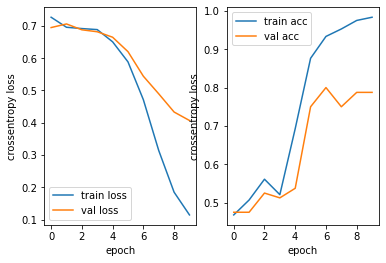

In [23]:
lossplot = plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('epoch')
plt.ylabel('crossentropy loss')
plt.legend()

accplot = plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.xlabel('epoch')
plt.ylabel('crossentropy loss')
plt.legend()
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(x_test_padded, y_test_labels)
print("Testing Dataset Loss:", round(test_loss,2))
print("Testing Dataset Accuracy:", round(test_accuracy,2))

7/7 [==============================] - 0s 2ms/step - loss: 0.5367 - accuracy: 0.7500
Testing Dataset Loss: 0.54
Testing Dataset Accuracy: 0.75


# Save and reload in my model for prediction

In [25]:
model_url = 'C:/Users/tedda/Desktop/Data Science Portfolio/Machine Learning/Sentiment Analysis/NLTK & TF Sentiment Analysis on Amazon Reviews/Exported Models/SentimentAnalysisModel_DeepNN.h5'
model.save(model_url)

In [26]:
SA_model = load_model(model_url)

# Make Predictions

In [27]:
predictions = SA_model.predict(x_test_padded)

print("Review:", x_test[124])
print("Actual Label:", "Positive Review" if y_test[124][1] == 1 else "Negative Review")
print("Predicted Label:", "Positive Review" if predictions[124][1] >= 0.5 else "Negative Review")

Review: really recommend faceplate since look nice elegant cool
Actual Label: Positive Review
Predicted Label: Positive Review
